<a href="https://colab.research.google.com/github/ruby199/build_DL_model/blob/main/Day3_02_GEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import PIL
import os
import matplotlib.pyplot as plt

In [26]:
(X_train, _ ), _ = keras.datasets.mnist.load_data()

In [27]:
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5

In [28]:
BATCH_SIZE = 256 #  number of samples in each batch of training data
BUFFER_SIZE = 60000 #  size of the buffer used for shuffling the training data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # When using the shuffle() function, TensorFlow maintains a buffer of BUFFER_SIZE elements from which it randomly samples the next batch. The buffer size should typically be set to a value larger than the batch size to ensure random sampling. 


discriminator function

In [29]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5,5), strides=(2,2),
                                  padding='same',
                                  input_shape=((28,28,1))))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Conv2D(128, (5,5), strides=(2,2),
                                  padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1 , activation='sigmoid'))
    return model

generator function

In [30]:
def make_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7,7,256)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1),padding='same',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2),padding='same',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5,5), strides=(2,2),padding='same',activation='tanh',use_bias=False))
    return model


Test generator and discriminator

In [31]:
generator = make_generator()
discriminator = make_discriminator_model()
noise = tf.random.normal([1, 100]) # random noise

In [32]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.45653054, -0.33375975,  1.3828017 , -0.4852148 , -0.14837267,
         0.44084182, -0.41746712,  0.5743614 ,  0.5904066 , -0.01695237,
        -0.75547844,  0.85862315,  0.74755996, -0.23400274,  1.1002638 ,
         0.99992627, -0.51461107, -1.8775465 ,  2.1909916 ,  0.8170922 ,
        -0.21718381, -0.55744374,  0.9732344 , -1.0082175 , -0.13887644,
        -1.1276139 ,  0.54473406, -0.00892081,  0.55396384,  1.038829  ,
         0.12230019,  0.3768415 ,  1.1048428 ,  0.22134162,  0.5257027 ,
         0.88702387,  1.6938938 ,  0.48315927, -1.8386251 ,  0.2756075 ,
        -0.444398  , -0.1264801 ,  0.06710972, -0.5317993 , -1.4196824 ,
        -0.17588925,  0.45816672, -0.8460145 ,  0.1566371 , -0.9957783 ,
         0.7286807 ,  0.02639073, -1.172615  ,  0.20903651,  1.792742  ,
        -0.6749804 ,  0.6067873 , -1.5777516 , -0.1580856 , -0.18807088,
        -0.81647885, -1.5540879 , -1.0228491 , -0.31869587, -1.6023403 ,
 

In [33]:
fake_image = generator(noise, training=False)
result = discriminator(fake_image, training=False)

In [34]:
print(result)

tf.Tensor([[0.5001251]], shape=(1, 1), dtype=float32)


In [35]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits parameter is used to specify whether the model's output values are raw logits or probabilities.

In [36]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # If it's correct, output all 1s; if it's incorrect, output all 0s.
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) 
  total_loss = real_loss + fake_loss
  return total_loss

In [37]:
def generator_loss(fake_output): # only cares about the fake_output
  return cross_entropy(tf.ones_like(fake_output), fake_output)

Build an Optimizer

In [38]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

check point

In [39]:
checkpoint_dir = '/content/check_point'
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


Selecting hyperparameters

In [40]:
# select hyperparameter
EPOCHS = 50
noise_dim = 100
num_example_to_generate = 16

seed = tf.random.normal([num_example_to_generate, noise_dim])

train step

- gradient tapes are used to track operations and calculate gradients in TensorFlow.

- Implementing custom training steps instead of using `model.fit()` directly in a GAN setup because of the unique training dynamics of GANs. 

In a GAN, the generator and discriminator models are trained in an adversarial manner, each trying to outperform the other. The generator aims to produce realistic synthetic samples, while the discriminator aims to correctly distinguish between real and fake samples.


**Why we use custom training steps for Train step**
- GAN training involves a competitive process between the generator and discriminator. 
- The generator and discriminator often have different update frequencies. 
- GANs often use custom loss functions specific to the generator and discriminator objectives.
-  Custom training steps offer fine-grained control over the training loop. 


By implementing custom training steps, you have the flexibility to fine-tune the training process according to the unique requirements and dynamics of GANs. While model.fit() provides a convenient high-level API for standard supervised learning tasks, GANs often require more specialized training procedures.

In [41]:
from tensorflow.python.ops.variables import trainable_variables

@tf.function
def train_step(images): # input: real images
    noise = tf.random.normal((BATCH_SIZE, noise_dim)) # generate one noise vector

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)

        # calculate the loss based on the prediction made by the discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # calculate the gradients
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))


In [42]:
def generate_and_save_images(model , epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, : , : , 0] * 127.5 + 127.5 , cmap = 'gray')
        plt.axis('off')
    
    plt.savefig(f'image_{epoch}.png') # save the generated image file
    plt.show()

In [43]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(epoch)
        generate_and_save_images(generator, epoch, seed)

0


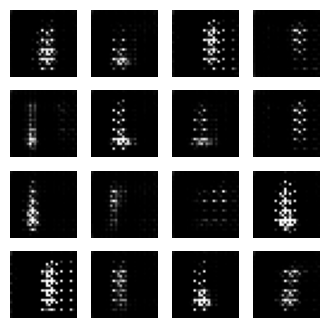

1


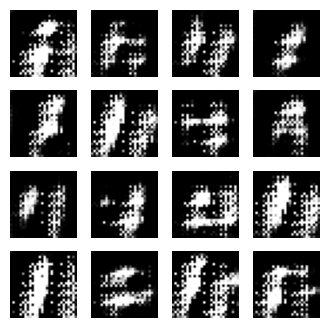

2


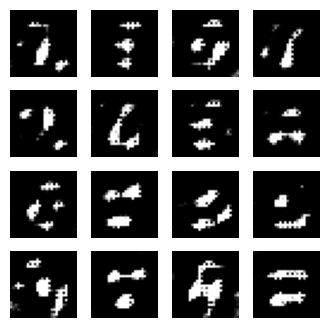

3


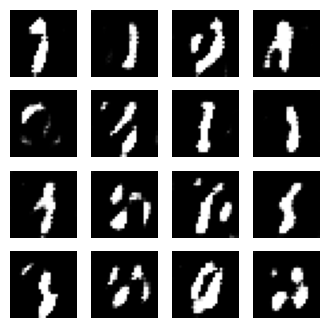

4


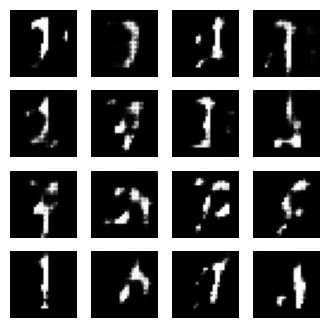

5


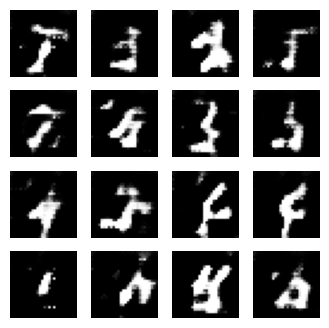

6


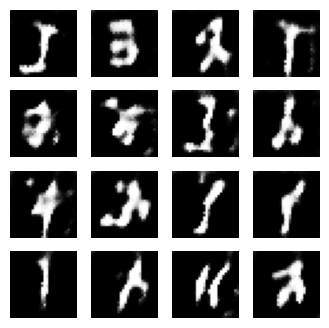

7


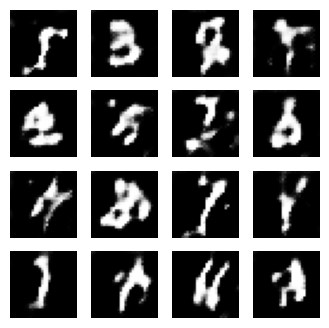

8


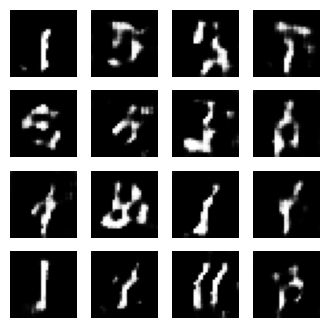

9


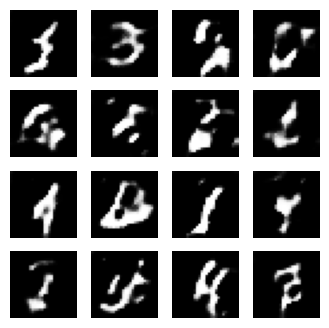

10


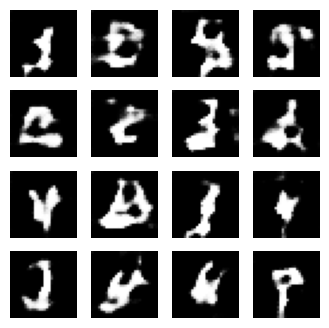

11


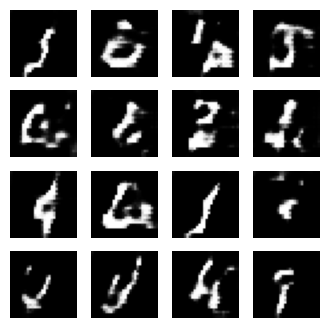

12


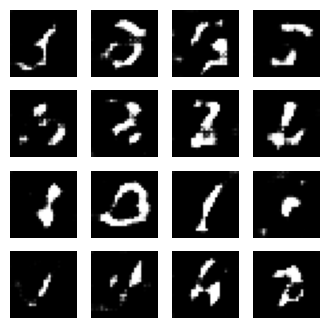

13


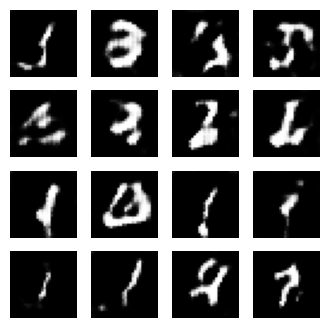

14


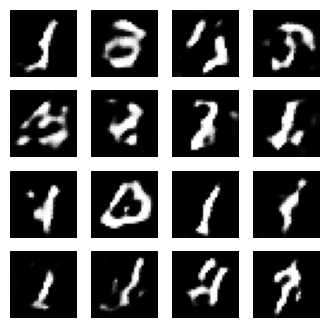

15


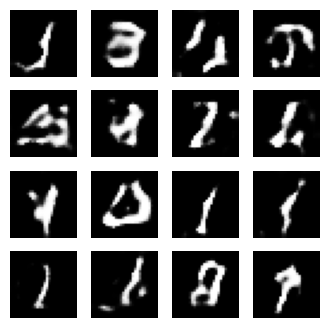

16


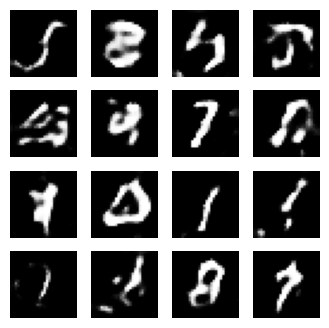

17


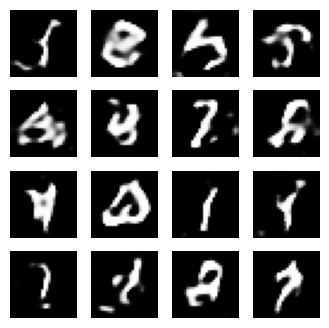

18


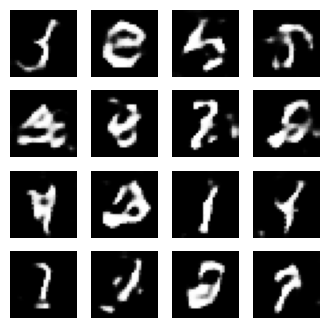

19


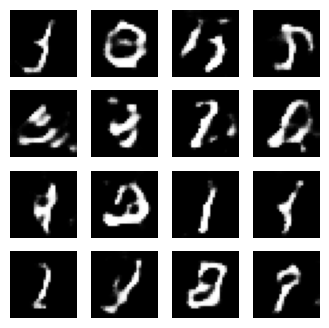

20


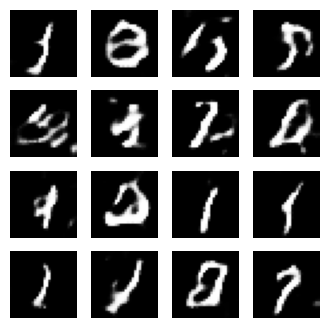

21


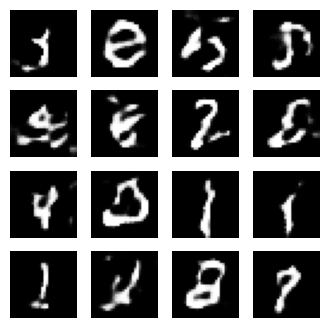

22


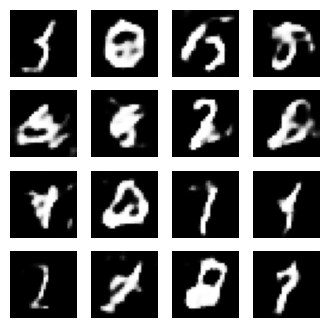

23


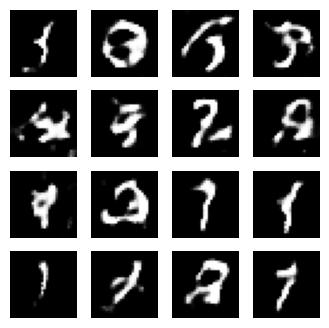

24


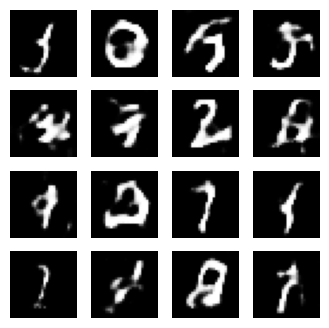

25


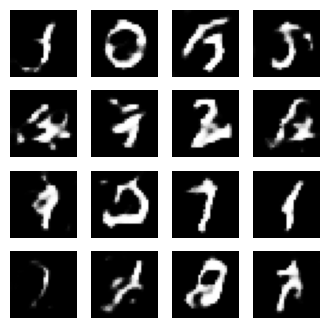

26


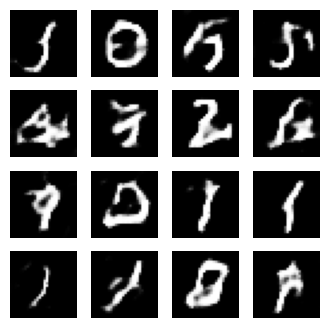

27


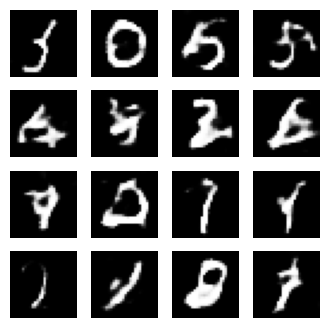

28


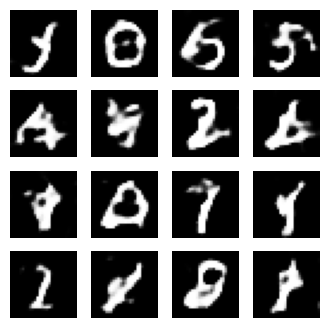

29


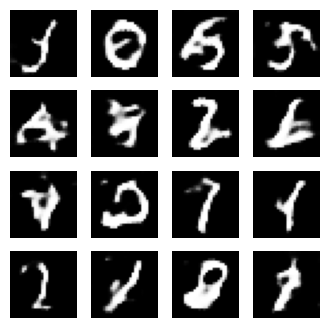

30


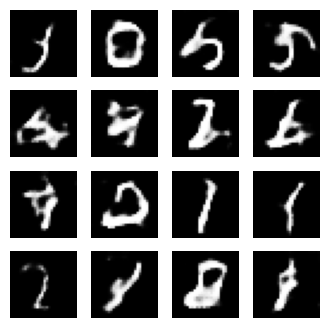

31


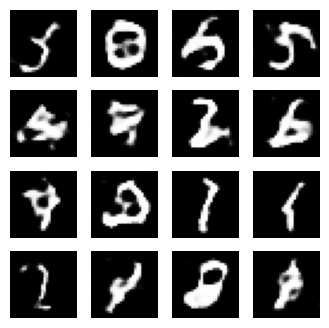

32


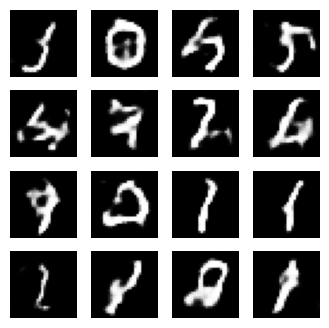

33


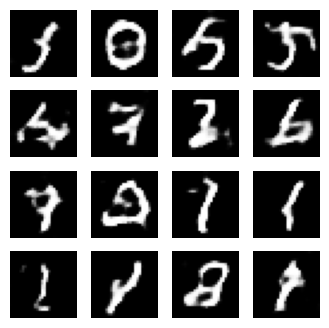

34


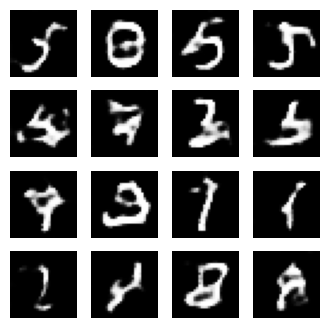

35


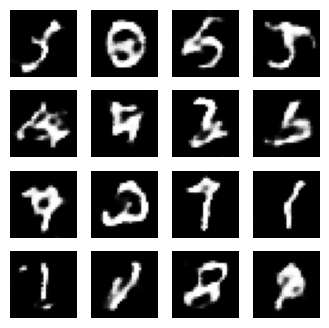

36


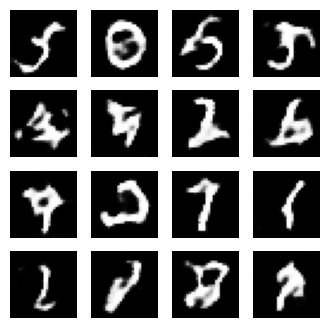

37


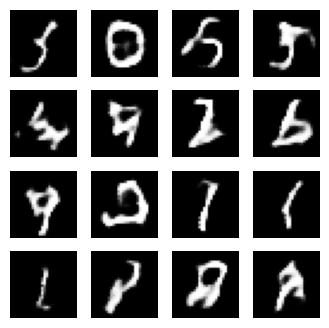

38


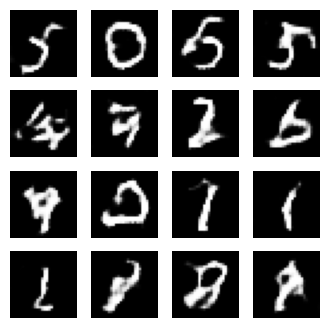

39


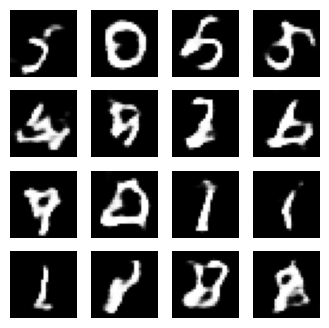

40


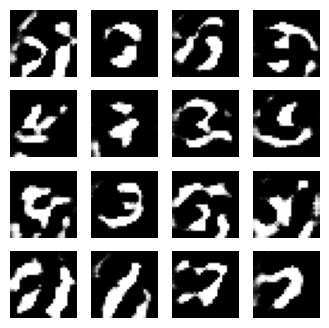

41


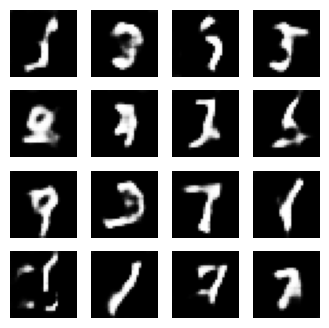

42


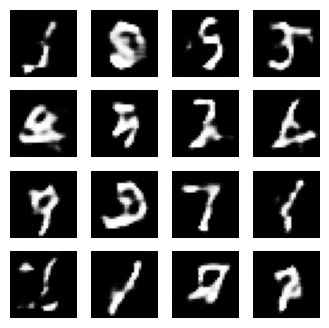

43


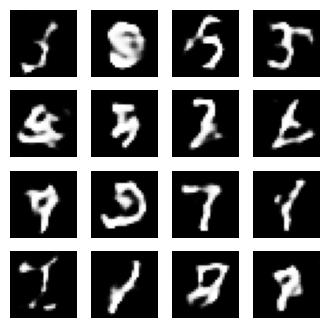

44


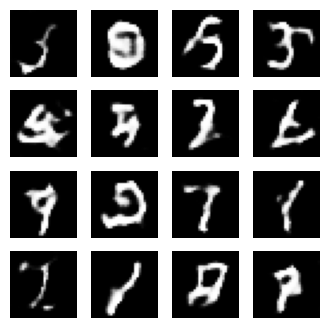

45


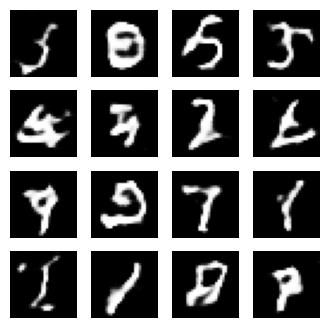

46


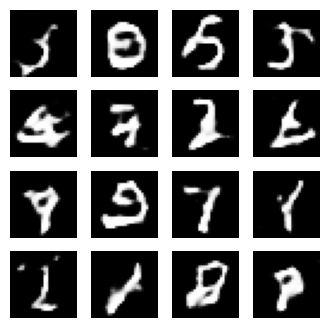

47


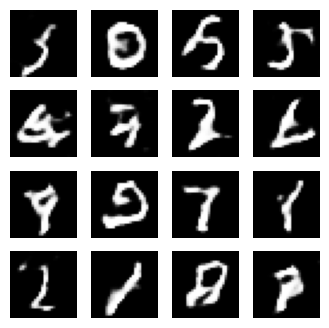

48


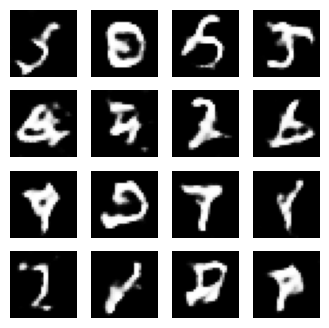

49


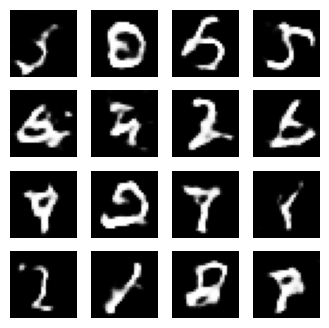

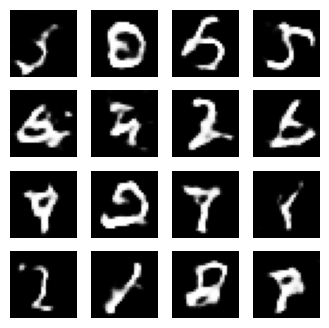

In [44]:
train(train_dataset, EPOCHS)
generate_and_save_images(generator, EPOCHS, seed)